In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import matplotlib.pyplot as plt
from src.Simulator.SSA import SSASimulator
import numpy as np
from src.Estimation.FullObsNN import IndividualReactionsNN
from src.Estimation.FullObsNN import DataPreparatorFullObs
from src.Models.utils import getReactionsForObservations
from src.Estimation.utils import createPropensityPlot
from src.Estimation.MLE import MLEstimator

2023-11-14 11:19:35.488715: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 11:19:35.490127: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 11:19:35.520354: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 11:19:35.521064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 11:19:36.045455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# NN for Birth Death Model
First, we build the dynamic model to create the training data

In [22]:
from src.Models.example_networks import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
x0 = model_bd.getDefaultInitialState()

We set up the NN model

In [23]:
data_preparator = DataPreparatorFullObs()
num_trajs = 100
for num_traj in range(num_trajs):
    y, t = simulator_bd.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_bd.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)
    
num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))
species_by_reaction = model_bd.getSpeciecByReaction()

custom_model = IndividualReactionsNN(num_outputs=num_unique_stoch, num_layers=2, num_neurons=8, learning_rate=0.001, inputs_by_output = species_by_reaction)
train_dataset = data_preparator.getTraindDataset()

We train the model on the training data

In [8]:
custom_model.fit(train_dataset, epochs=3)

Epoch 1/3
[<tf.Variable 'dense/kernel:0' shape=(1, 8) dtype=float32>, <tf.Variable 'dense/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'dense_1/kernel:0' shape=(8, 8) dtype=float32>, <tf.Variable 'dense_1/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'dense_2/kernel:0' shape=(8, 1) dtype=float32>, <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32>, <tf.Variable 'dense_3/kernel:0' shape=(1, 8) dtype=float32>, <tf.Variable 'dense_3/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'dense_4/kernel:0' shape=(8, 8) dtype=float32>, <tf.Variable 'dense_4/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'dense_5/kernel:0' shape=(8, 1) dtype=float32>, <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32>]
12
[<tf.Variable 'dense/kernel:0' shape=(1, 8) dtype=float32>, <tf.Variable 'dense/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'dense_1/kernel:0' shape=(8, 8) dtype=float32>, <tf.Variable 'dense_1/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'dense_2/kernel:0' shape=(8, 1) dtyp

We plot the estimation results

7/7 [==============================] - 0s 2ms/step


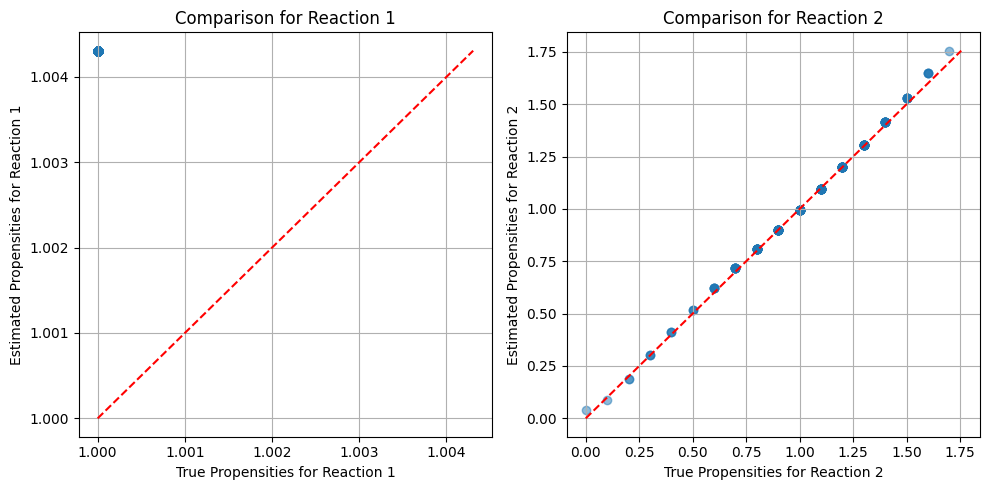

In [15]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_bd.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)
plt.savefig("bd_comparison.svg")

Lets compare it with the MLE 

In [ ]:
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()
plt.savefig("bd_comparison_MLE.svg")

# NN for Lotka-Voltera Model

In [2]:
from src.Models.paper_examples import ThreeSpeciesModel
model_lv = ThreeSpeciesModel()
simulator_lv = SSASimulator(model_lv)

parameters = model_lv.getDefaultParameter()
x0 = model_lv.getDefaultInitialState()

In [3]:

data_preparator = DataPreparatorFullObs()

num_trajs = 5
for num_traj in range(num_trajs):
    y, t = simulator_lv.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lv.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))
species_by_reaction = model_lv.getSpeciecByReaction()
custom_model = IndividualReactionsNN(num_outputs=num_unique_stoch, inputs_by_output=species_by_reaction,  num_layers=2, num_neurons=64, learning_rate=0.01)
train_dataset = data_preparator.getTraindDataset()

2023-11-14 10:58:31.720235: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-11-14 10:58:31.720305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: markphillip
2023-11-14 10:58:31.720316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: markphillip
2023-11-14 10:58:31.720457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.12
2023-11-14 10:58:31.720500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  535.104.12  Release Build  (dvs-builder@U16-I3-A14-4-4)  Wed Sep 20 09:32:00 UTC 2023
GCC version:  gcc version 11.4.0 (Ubuntu 11.4.0-1ubuntu1~22.04) 
"


In [13]:
custom_model.fit(train_dataset, epochs=5)

Epoch 1/5
[<tf.Variable 'dense_6/kernel:0' shape=(1, 64) dtype=float32>, <tf.Variable 'dense_6/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dense_7/kernel:0' shape=(64, 64) dtype=float32>, <tf.Variable 'dense_7/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dense_8/kernel:0' shape=(64, 1) dtype=float32>, <tf.Variable 'dense_8/bias:0' shape=(1,) dtype=float32>, <tf.Variable 'dense_9/kernel:0' shape=(1, 64) dtype=float32>, <tf.Variable 'dense_9/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dense_10/kernel:0' shape=(64, 64) dtype=float32>, <tf.Variable 'dense_10/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dense_11/kernel:0' shape=(64, 1) dtype=float32>, <tf.Variable 'dense_11/bias:0' shape=(1,) dtype=float32>, <tf.Variable 'dense_12/kernel:0' shape=(1, 64) dtype=float32>, <tf.Variable 'dense_12/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dense_13/kernel:0' shape=(64, 64) dtype=float32>, <tf.Variable 'dense_13/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dense_

135/135 [==============================] - 1s 2ms/step


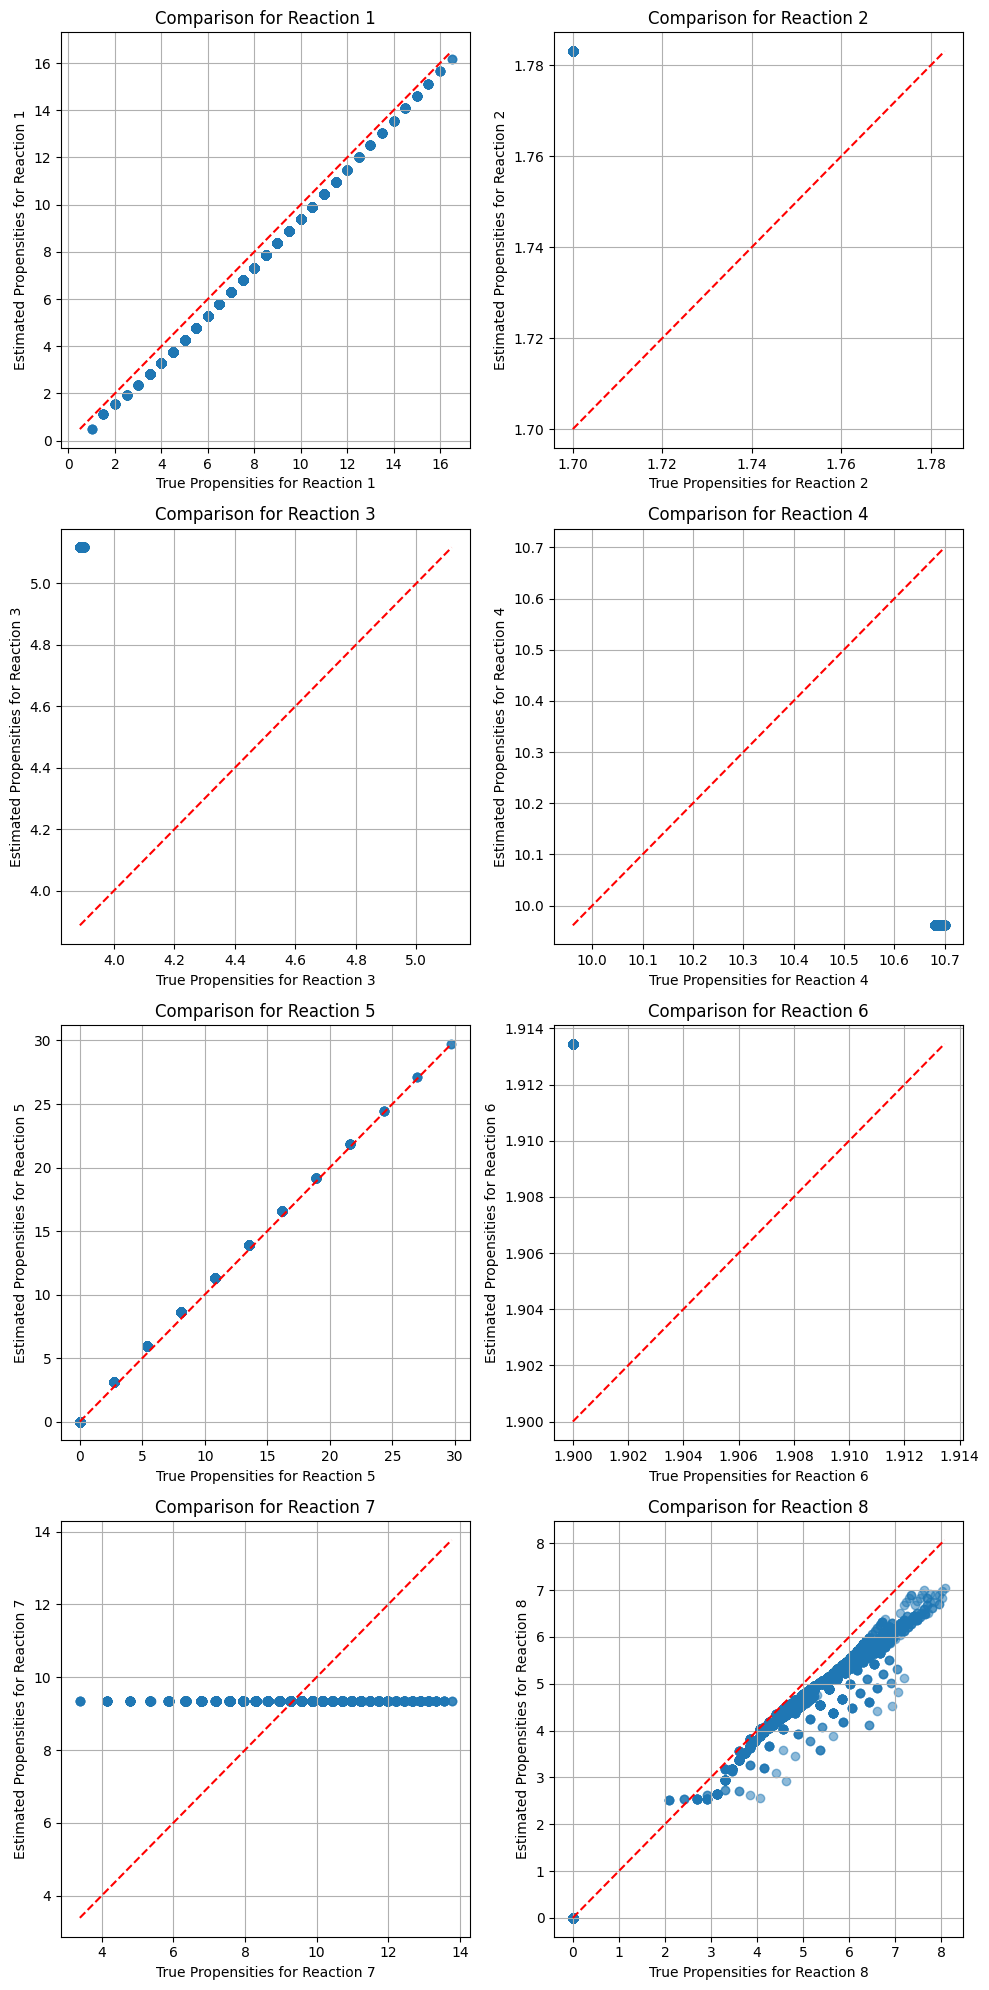

In [15]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lv.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]
fig = createPropensityPlot(nn_predictions, true_props_unique)

# NN for Chemical Reaction Network Model


In [4]:
from src.Models.paper_examples import ChemicalReactionNetwork
model_crn = ChemicalReactionNetwork()
simulator_crn = SSASimulator(model_crn)

parameters = model_crn.getDefaultParameter()
x0 = model_crn.getDefaultInitialState()

In [30]:
data_preparator = DataPreparatorFullObs(batch_size=512)

num_trajs = 10
for num_traj in range(num_trajs):
    y, t = simulator_crn.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_crn.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))
species_by_reaction = model_crn.getSpeciecByReaction()

custom_model = IndividualReactionsNN(num_outputs=num_unique_stoch, num_layers=2, num_neurons=128, inputs_by_output=species_by_reaction, learning_rate=0.01)
train_dataset = data_preparator.getTraindDataset()

In [31]:
custom_model.fit(train_dataset, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 684206.1250
Epoch 2/1000
1/1 [==============================] - 0s 11ms/step - loss: 501001.5625
Epoch 3/1000
1/1 [==============================] - 0s 12ms/step - loss: 564576.1875
Epoch 4/1000
1/1 [==============================] - 0s 13ms/step - loss: 517896.7188
Epoch 5/1000
1/1 [==============================] - 0s 12ms/step - loss: 464195.8438
Epoch 6/1000
1/1 [==============================] - 0s 12ms/step - loss: 416090.1250
Epoch 7/1000
1/1 [==============================] - 0s 11ms/step - loss: 373170.9375
Epoch 8/1000
1/1 [==============================] - 0s 11ms/step - loss: 361294.9688
Epoch 9/1000
1/1 [==============================] - 0s 12ms/step - loss: 343063.5625
Epoch 10/1000
1/1 [==============================] - 0s 11ms/step - loss: 323149.0938
Epoch 11/1000
1/1 [==============================] - 0s 12ms/step - loss: 313667.3438
Epoch 12/1000
1/1 [==============================] - 0s 10ms/step

1/1 [==============================] - 0s 242ms/step


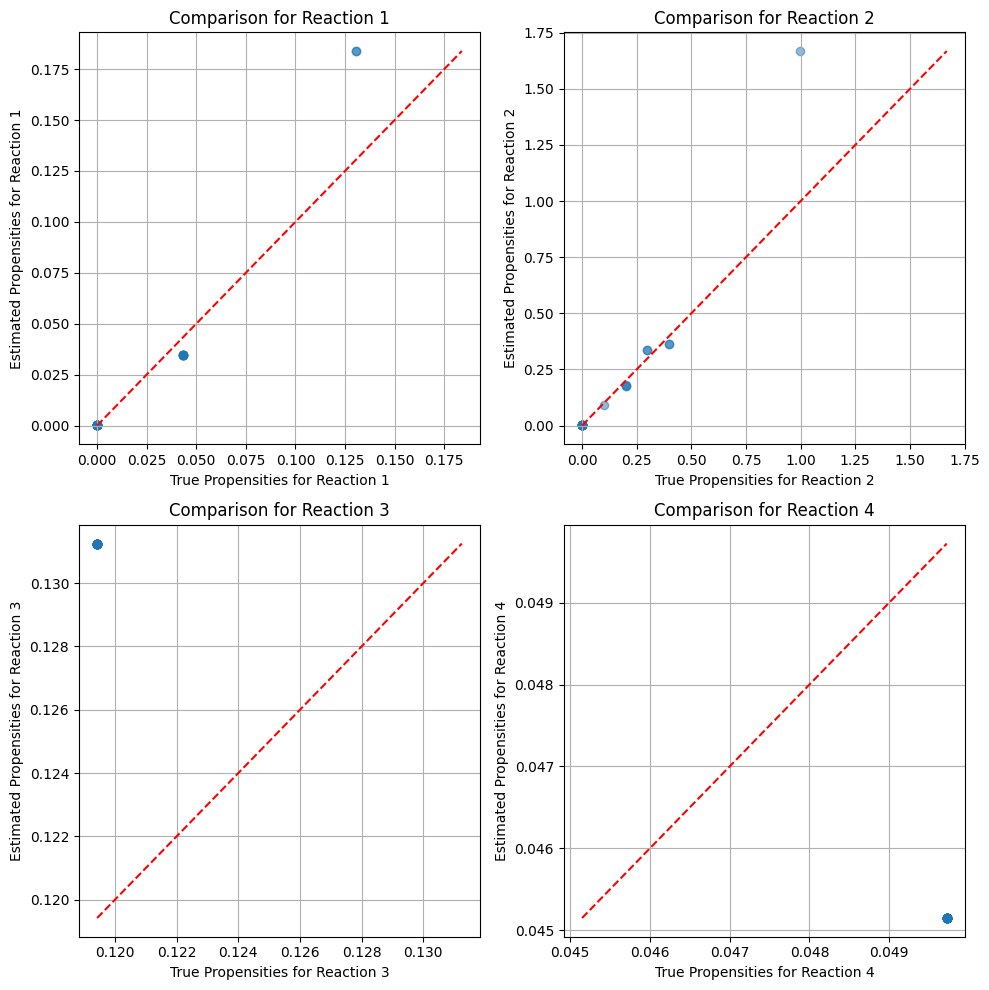

In [32]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_crn.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)

Compare with MLE

/tmp/ipykernel_143788/13457184.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


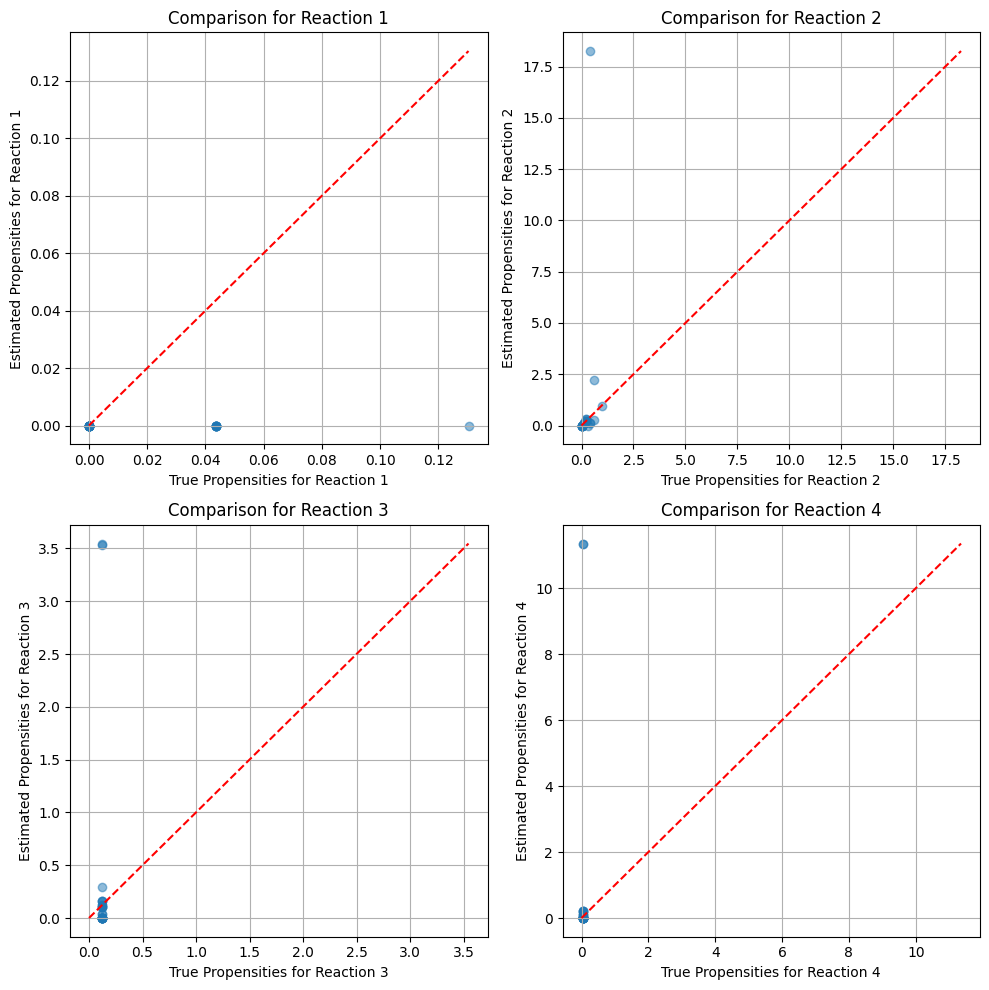

In [11]:
estimator = MLEstimator(model_crn, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()

# Lac-Gfp Model


In [2]:
from src.Models.example_networks import LacGfp
model_lac = LacGfp()
simulator_lac = SSASimulator(model_lac)

parameters = model_lac.getDefaultParameter()
x0 = model_lac.getDefaultInitialState()
y, t = simulator_lac.run_ssa(x0, 10, parameters)

In [3]:

data_preparator = DataPreparatorFullObs()
num_trajs = 5
for num_traj in range(num_trajs -1):
    y, t = simulator_lac.run_ssa(x0, 10, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lac.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

num_states = y.shape[1]
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lac.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))
species_by_reaction = model_lac.getSpeciecByReaction()

train_dataset = data_preparator.getTraindDataset()

2023-11-14 11:19:53.924867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-11-14 11:19:53.924971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: markphillip
2023-11-14 11:19:53.924984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: markphillip
2023-11-14 11:19:53.925190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.12
2023-11-14 11:19:53.925253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  535.104.12  Release Build  (dvs-builder@U16-I3-A14-4-4)  Wed Sep 20 09:32:00 UTC 2023
GCC version:  gcc version 11.4.0 (Ubuntu 11.4.0-1ubuntu1~22.04) 
"


In [7]:
custom_model = IndividualReactionsNN(num_outputs=num_unique_stoch, num_layers=2,num_neurons=64, inputs_by_output=species_by_reaction)

In [6]:
list(train_dataset.take(1))

In [6]:
custom_model.fit(train_dataset, epochs=100)

29/29 [==============================] - 0s 2ms/step


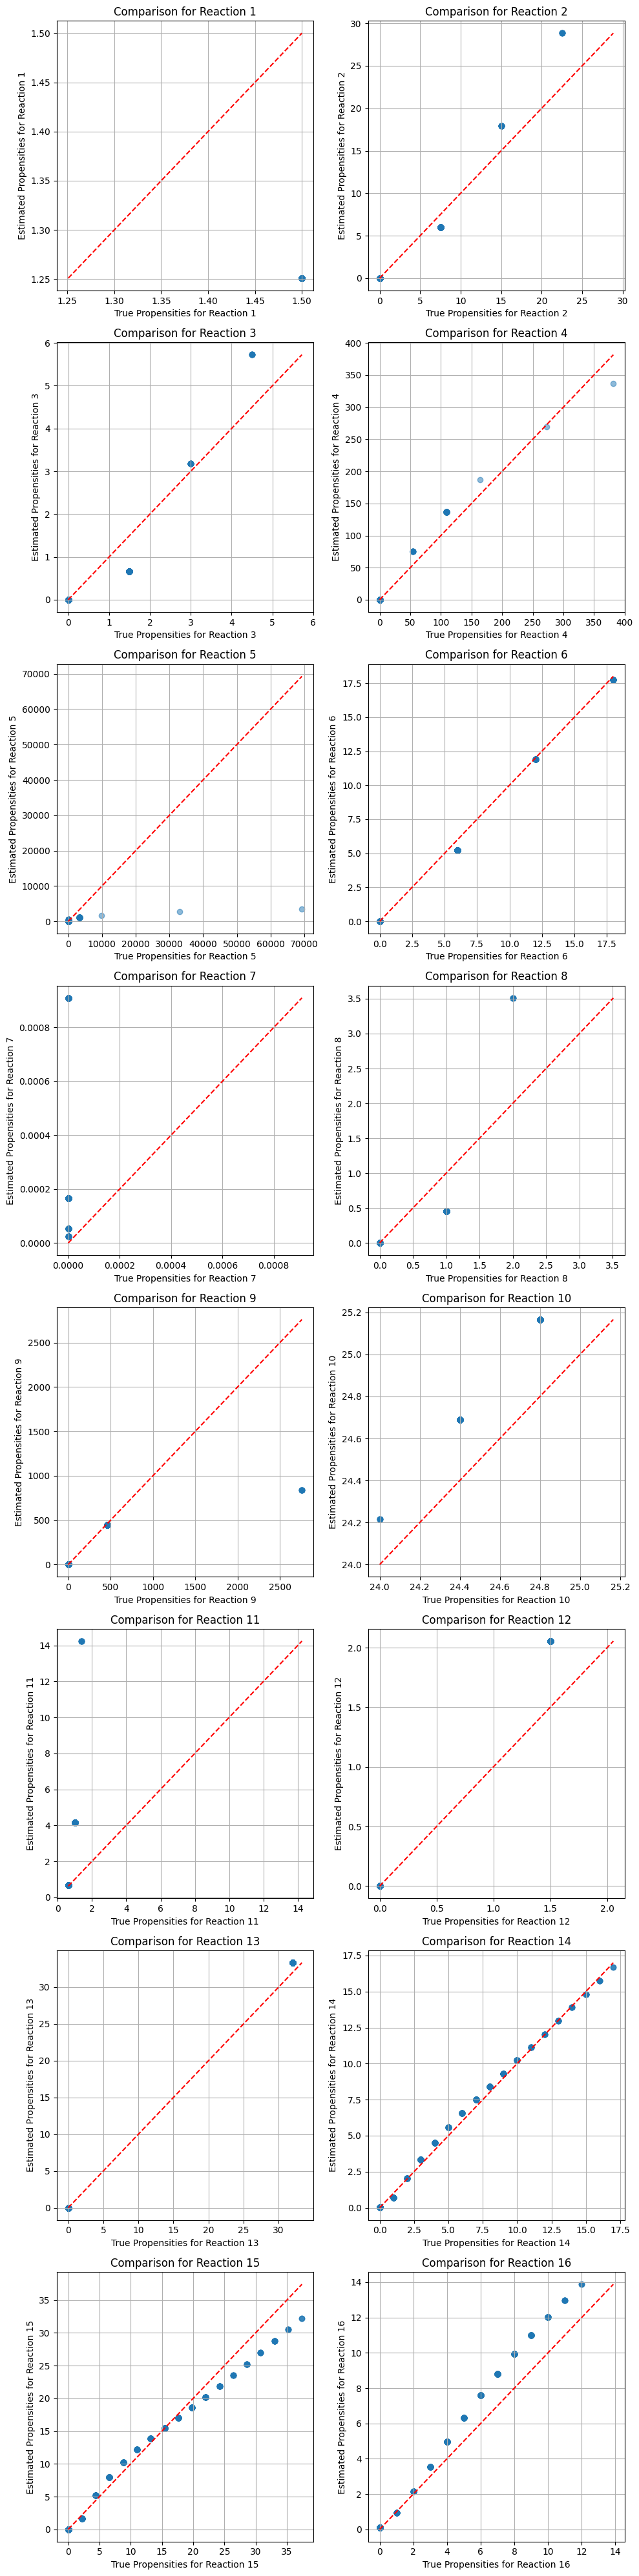

In [88]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lac.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)

## Training the Autoencoder

In [4]:
import  tensorflow as tf
from src.Estimation.FullObsNN import CombinedReactionsWithTrainedEncoder, CombinedReactionsNN
from src.Estimation.FullObsNN import AutoEncoder

In [5]:

# def get_max_values(data: tf.data.Dataset):
#     for x in data:
#         init_max = tf.zeros(x.shape[-1], dtype = tf.int64)
#         break
#     
#     for x in data:
#         max_ = tf.reduce_max(x, axis=0)
#         new_mat = tf.stack([max_, init_max], axis=0)
#         max_ = tf.reduce_max(new_mat, axis = 0)
#         init_max = max_
#     return max_       
        
x_data = train_dataset.map(lambda x,y,z:x)   
# max_values = get_max_values(x_data)
# x_data=x_data.map(lambda x: x/max_values)

In [7]:
# autoencoder = AutoEncoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
autoencoder.fit(x_data,
                epochs=300)

Epoch 1/300
50/50 [==============================] - 0s 925us/step - loss: 243.1241
Epoch 2/300
50/50 [==============================] - 0s 1ms/step - loss: 234.8064
Epoch 3/300
50/50 [==============================] - 0s 857us/step - loss: 238.3458
Epoch 4/300
50/50 [==============================] - 0s 985us/step - loss: 239.4540
Epoch 5/300
50/50 [==============================] - 0s 882us/step - loss: 239.4483
Epoch 6/300
50/50 [==============================] - 0s 899us/step - loss: 237.8084
Epoch 7/300
50/50 [==============================] - 0s 747us/step - loss: 235.5346
Epoch 8/300
50/50 [==============================] - 0s 1ms/step - loss: 233.4102
Epoch 9/300
50/50 [==============================] - 0s 817us/step - loss: 232.1365
Epoch 10/300
50/50 [==============================] - 0s 772us/step - loss: 231.0972
Epoch 11/300
50/50 [==============================] - 0s 836us/step - loss: 229.9198
Epoch 12/300
50/50 [==============================] - 0s 959us/step - loss: 22

In [14]:
# h = list(x_data.take(1))
# autoencoder(h)

In [9]:
model = CombinedReactionsWithTrainedEncoder(autoencoder.encoder, num_outputs=16)

In [10]:
model.layers[0].layers[0].trainable

False

In [11]:
model.fit(train_dataset, epochs=100)

Epoch 1/100
[<tf.Variable 'dense_2/kernel:0' shape=(4, 16) dtype=float32>, <tf.Variable 'dense_2/bias:0' shape=(16,) dtype=float32>]
2
[<tf.Variable 'dense_2/kernel:0' shape=(4, 16) dtype=float32>, <tf.Variable 'dense_2/bias:0' shape=(16,) dtype=float32>]
2
50/50 [==============================] - 0s 2ms/step - loss: -175248.7812
Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: -199117.4062
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: -213521.9219
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: -221921.6875
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: -226292.9531
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: -229554.9844
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: -232311.7031
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: -234561.7656
Epoch 9/100
50/50 [==============================] - 0s 2ms/step -

In [12]:
nn_predictions = model.predict(h)

8/8 [==============================] - 0s 2ms/step


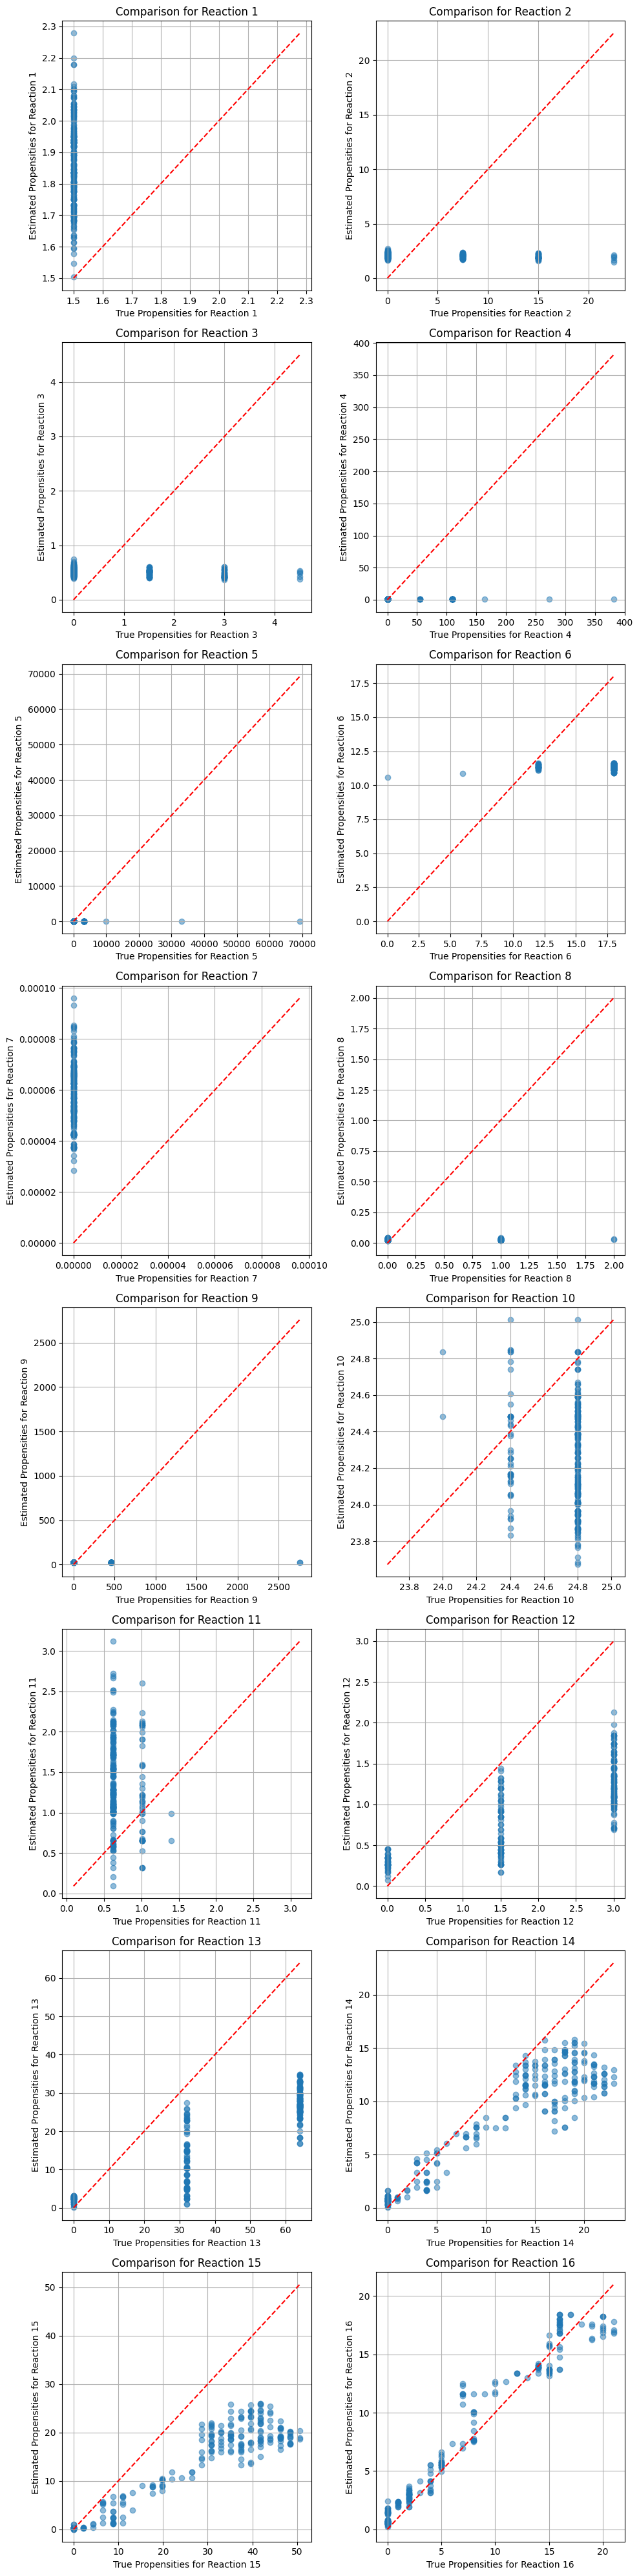

In [13]:
true_props = np.array([model_lac.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique[:256])

(256, 16)